In [5]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip /content/cifake-real-and-ai-generated-synthetic-images.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/REAL/4500 (10).jpg  
  inflating: /content/train/REAL/4500 (2).jpg  
  inflating: /content/train/REAL/4500 (3).jpg  
  inflating: /content/train/REAL/4500 (4).jpg  
  inflating: /content/train/REAL/4500 (5).jpg  
  inflating: /content/train/REAL/4500 (6).jpg  
  inflating: /content/train/REAL/4500 (7).jpg  
  inflating: /content/train/REAL/4500 (8).jpg  
  inflating: /content/train/REAL/4500 (9).jpg  
  inflating: /content/train/REAL/4500.jpg  
  inflating: /content/train/REAL/4501 (10).jpg  
  inflating: /content/train/REAL/4501 (2).jpg  
  inflating: /content/train/REAL/4501 (3).jpg  
  inflating: /content/train/REAL/4501 (4).jpg  
  inflating: /content/train/REAL/4501 (5).jpg  
  inflating: /content/train/REAL/4501 (6).jpg  
  inflating: /content/train/REAL/4501 (7).jpg  
  inflating: /content/train/REAL/4501 (8).jpg  
  inflating: /content/train/REAL/4501 (9).jpg  
  inflating: /content/train/REAL/4501.j

In [8]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [9]:
# Define your project name
project_name = 'CIFAKE'

# List your models
model_names = [
    'ResNET50',
    'EfficientNET'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

In [10]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

In [11]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


        REAL   FAKE
train  50000  50000
       REAL   FAKE
test  10000  10000


<Axes: >

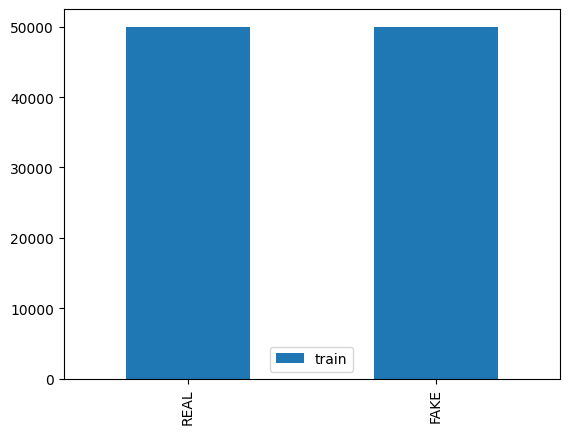

In [12]:
train_count.transpose().plot(kind='bar')

<Axes: >

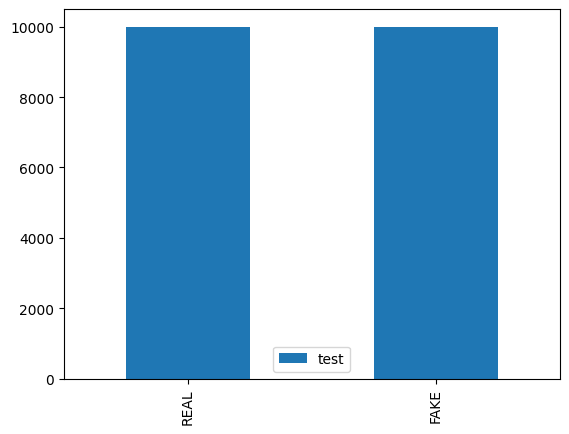

In [13]:
test_count.transpose().plot(kind='bar')

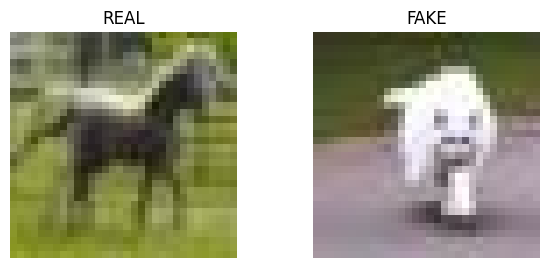

In [15]:
label = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(label, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [17]:
image = '/content/train/REAL/4991 (9).jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (32, 32, 3)


In [18]:
train_dir = '/content/train'
test_dir = '/content/test'
batch_size = 64
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="binary",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="binary",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [20]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet',pooling="max"
                                               )

In [21]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [22]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(1,activation='sigmoid')
                    ])
    return model

In [23]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
cnn_path = '/content/CIFAKE/ResNET50'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [27]:
ResNet_model_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=3,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          verbose=1,
                          callbacks = callbacks
                         )

Epoch 1/3
1563/1563 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9517 - precision: 0.9531 - recall: 0.9501
Epoch 1: val_loss improved from inf to 0.11528, saving model to /content/CIFAKE/ResNET50/ResNet50_Transfer_Learning.keras
1563/1563 [==============================] - 511s 327ms/step - loss: 0.1273 - accuracy: 0.9517 - precision: 0.9531 - recall: 0.9501 - val_loss: 0.1153 - val_accuracy: 0.9556 - val_precision: 0.9319 - val_recall: 0.9832
Epoch 2/3
1563/1563 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9661 - precision: 0.9660 - recall: 0.9662
Epoch 2: val_loss improved from 0.11528 to 0.10654, saving model to /content/CIFAKE/ResNET50/ResNet50_Transfer_Learning.keras
1563/1563 [==============================] - 508s 325ms/step - loss: 0.0924 - accuracy: 0.9661 - precision: 0.9660 - recall: 0.9662 - val_loss: 0.1065 - val_accuracy: 0.9607 - val_precision: 0.9852 - val_recall: 0.9356
Epoch 3/3
1563/1563 [=========================

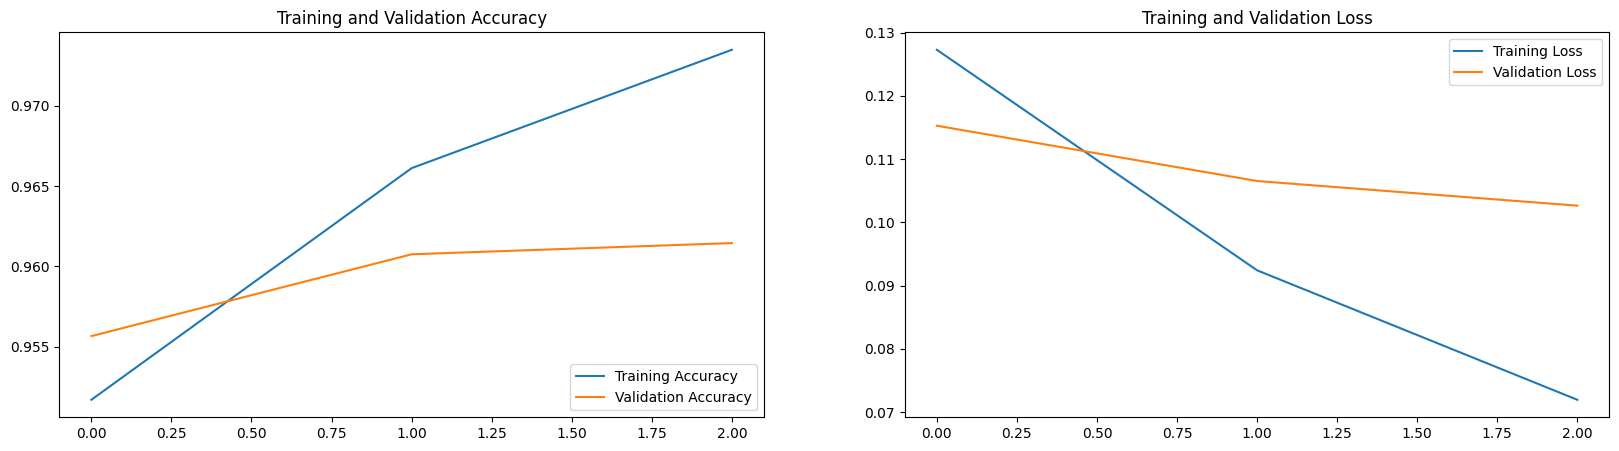

In [31]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()



plot_training_history(ResNet_model_history)

In [33]:
test_loss, test_accu, test_precision, test_recall = model.evaluate(test_generator) # Assign the returned values to four variables
print(test_loss, test_accu, test_precision, test_recall) # Print all returned values

313/313 [==============================] - 58s 185ms/step - loss: 0.1026 - accuracy: 0.9614 - precision: 0.9807 - recall: 0.9414
0.10264091938734055 0.9614499807357788 0.9807271361351013 0.9413999915122986


Classification Report:
               precision    recall  f1-score   support

        FAKE       0.50      1.00      0.67     10000
        REAL       0.00      0.00      0.00     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



In [36]:
import random

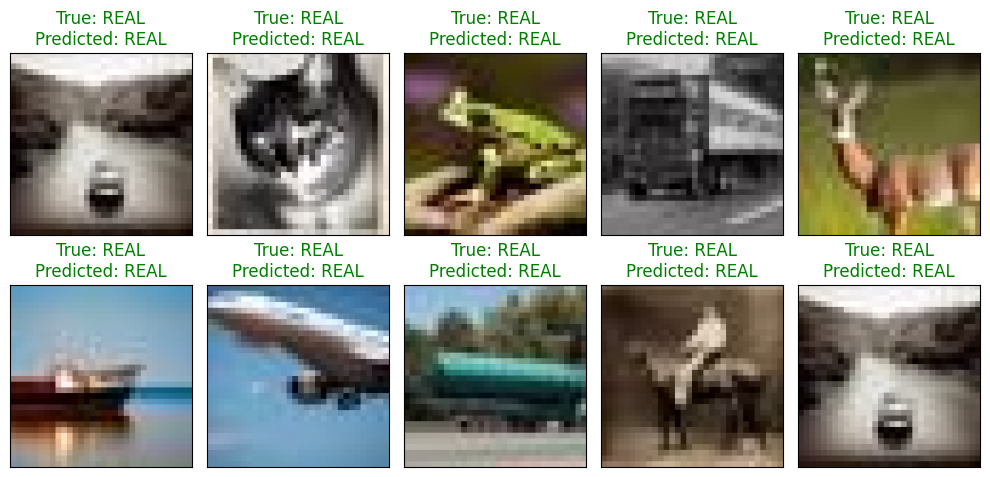

In [38]:
# Emotion classes for the dataset
Emotion_Classes = ['REAL','FAKE']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

313/313 [==============================] - 58s 185ms/step


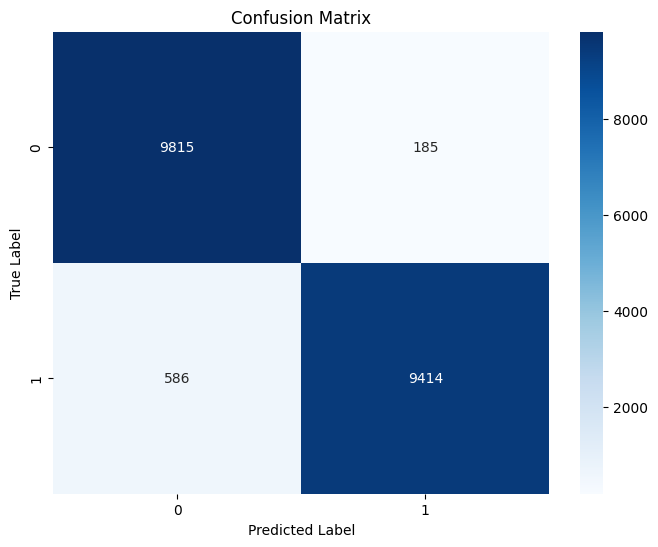

In [39]:
# Get the predictions from the model
predictions = model.predict(test_generator, steps=test_steps_epoch)
# Convert the predictions to class labels
predicted_classes = np.where(predictions > 0.5, 1, 0)
# Generate the confusion matrix
cm = confusion_matrix(test_generator.classes, predicted_classes)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [40]:
model.save("Test_model.keras")

In [41]:
'''
saved model for deployment
'''

'\nsaved model for deployment \n'